<h1>
Introduction to SuperNeuroABM
</h1>
<p>
    SuperNeuroABM is a pure-Python Agent-Based Modeling (ABM) software for training spiking neural networks (SNN). ABM is a popular modeling technique for simulating complex adaptive systems. SuperNeuroABM takes a complex adaptive systems perspective to simulating SNNs by modeling neurons as autonomous agents. This approach has proven to be advantagous by allowing for easier parallelism and stronger scaling through GPU computing and allowing the AI practioner to specify multiple breeds of neuron and synapse mechanisms within a single SNN for heterogenous simulations.
</p>
<p>
    SuperNeuroABM provides both CPU and GPU support. In GPU mode, neuron properties are convereted to agent data tensors that are distributed across GPU threads using Numba. Each agent is processed by a single GPU thread, which executes the neuronal and synaptic step functions. 
</p>
<div>
    <img src="img/systemoverview.png" width="1000" alt="System Overview" />
</div>

SuperNeuroABM can be installed from pypi.org using `pip`

In [2]:
!pip uninstall -y superneuroabm
!pip install superneuroabm
#!pip install matplotlib #Uncomment if your system does not have matplotlib installed

Found existing installation: SuperNeuroABM 0.2.0
Uninstalling SuperNeuroABM-0.2.0:
  Successfully uninstalled SuperNeuroABM-0.2.0


Import the `NeuromorhpicModel` class from `superneuroabm.model`

In [3]:
from superneuroabm.model import NeuromorphicModel

<p>
    First, we will model a 3-neuron architecture that includes an input neuron, hidden neuron, and output neuron as shown in the figure below. 
    Each neuron will have a threshold of 1.0, reset state of -1.0, and refractory period of 1.0.
</p>
<p>
    These neurons will be connected by two synapses with weights of 4 and 2 and synaptic delays of 2 and 3, respectively.
</p>

<div>
    <img src="img/neuralnetworkarchitecture.png" width="500" alt="SNN architecture" />
</div>

In [4]:
neuron_threshold = 1.0
neuron_reset = -1.0
neuron_refractory = 1.0


snn_model = NeuromorphicModel(use_cuda=False)

neurons = {"input": None, "hidden": None, "output": None}

for neuron_name in neurons.keys():
    neurons[neuron_name] = snn_model.create_neuron(
        threshold=neuron_threshold,
        reset_state=neuron_reset,
        refractory_period=neuron_refractory,
    )

print(neurons)

{'input': 0, 'hidden': 1, 'output': 2}


In [5]:
snn_model.create_synapse(neurons["input"], neurons["hidden"], 
            synaptic_delay = 2,
            weight = 4,
        )

snn_model.create_synapse(neurons["hidden"], neurons["output"],
            synaptic_delay = 3,                  
            weight = 2,
        )

Next, we will apply input spikes to the input neuron at times 0 and 10 with intensities 2 and 4, respectively.

In [7]:
input_spikes = {0: 2, 10: 4} # time -> intensity pairs
# Apply Spikes:
for spike_time in input_spikes:
    snn_model.spike(neuron_id = neurons["input"], tick = spike_time, value = input_spikes[spike_time])

Now we can setup and run the simulation. We will execute the simulation for 100 time steps

In [8]:
sim_time = 100
# Setup the model
# Using output_buffer_len = sim_time so that spikes are tracked for entire simulation
snn_model.setup(output_buffer_len = sim_time)

#Begin simulation:
snn_model.simulate(ticks=sim_time, update_data_ticks=1)

Simulation Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1.95kTick/s]


Simulation complete! Now we can query the spike times of our neurons using `get_spikes(...)`

In [9]:
# Monitor the output spikes from all neurons:
input_spike_times = snn_model.get_spikes(neuron_id = neurons["input"])
hidden_spike_times = snn_model.get_spikes(neuron_id = neurons["hidden"])
output_spike_times = snn_model.get_spikes(neuron_id = neurons["output"])

print(f"input neuron spike times: {input_spike_times}")
print(f"input neuron spike times: {hidden_spike_times}")
print(f"input neuron spike times: {output_spike_times}")

input neuron spike times: [0, 10]
input neuron spike times: [2, 12]
input neuron spike times: [5]


Below is some code to visualize the above as a spike raster plot

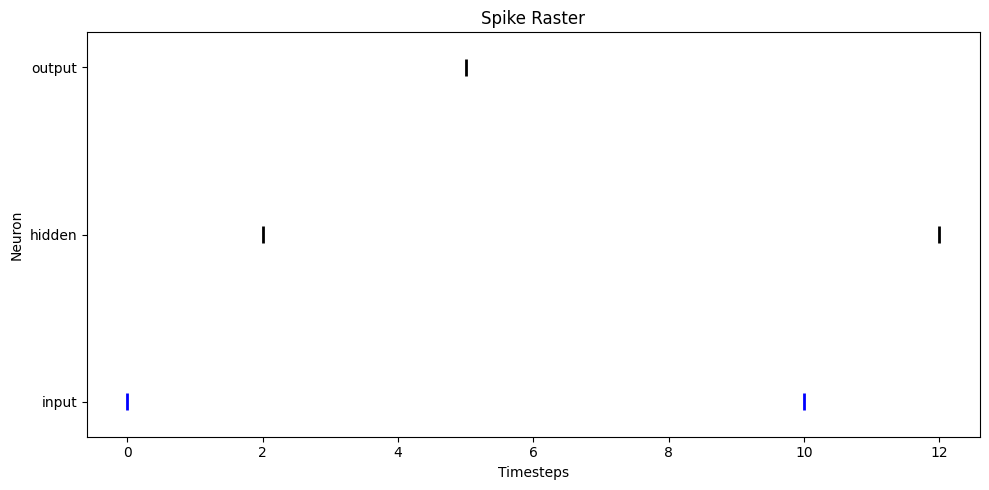

In [41]:
import matplotlib.pyplot as plt

network_spikes = []
for neuron_id in neurons.values():
    network_spikes.append(snn_model.get_spikes(neuron_id))

colors1 = ['b', 'k', 'k']  #Input spikes in blue and network spikes in black
fig, axs = plt.subplots(1,1,figsize=(10,5))
axs.eventplot(network_spikes,colors=colors1,lineoffsets=1,linelengths=0.1,linewidths=2.0)
axs.set_yticks(list(neurons.values()))
axs.set_yticklabels(list(neurons.keys()))
plt.title('Spike Raster')
plt.xlabel('Timesteps')
plt.ylabel('Neuron')
plt.tight_layout()

<h1>
    Heterogenous Mechanisms 
</h1>

Next, we will modify the network architecture to use two neuron mechanisms instead of one. 
SuperNeuroABM lets us do this by defining breeds. A dictionary may be passed upon creation of the neuromorphic model whose keys are names of neuron breeds and values are lists of step functions that the respective breed should execute. Note the step function list should be provided in order of execution. 

The architecture used is displayed in the image below
<div>
    <img src="img/neuralnetworkarchitectureSTDP.png" width="600" alt="SNN architecture with STDP" />
</div>

First, we need to describe our breeds in a dictionary and use it to initialize a new model. We can use predefined step functions that SuperNeuroABM provides for this purpose

In [14]:
from superneuroabm.neuron import neuron_step_func, synapse_step_func, synapse_with_stdp_step_func

neuron_breed_info = {"LIF": [neuron_step_func, synapse_step_func], "LIFForwardSTDP": [neuron_step_func, synapse_with_stdp_step_func]}
multibreed_model = NeuromorphicModel(use_cuda=False, neuron_breed_info=neuron_breed_info)

Next let's create the three neurons. However, this time we will use the `breed` parameter to specify which breed the Neuron will belong to.

In [15]:
 # Create neurons
input_0 = multibreed_model.create_neuron(
    breed="LIF", threshold=0.0
)
input_1 = multibreed_model.create_neuron(breed="LIFForwardSTDP", threshold=0.0)
output_2 = multibreed_model.create_neuron(breed="LIF", threshold=1.0)

# Create synapses
multibreed_model.create_synapse(
    pre_neuron_id=input_0, post_neuron_id=output_2, weight=4, synaptic_delay = 5,
)
multibreed_model.create_synapse(
    pre_neuron_id=input_1, post_neuron_id=output_2, weight=2, synaptic_delay = 3,
)

Next, let's add spikes to the model and simulate

In [18]:
input_spikes = {
    3: [
        (input_1, 1),
    ],
    5: [
        (input_0, 1),
    ],
    7: [
        (input_0, 1),
        (input_1, 1),
    ],
} # time -> (neuron_id, intensity)
for time in input_spikes:
    for neuron, value in input_spikes[time]:
        multibreed_model.spike(neuron_id=neuron, tick=time, value=value)

# Setup and simulate
multibreed_model.setup(output_buffer_len=sim_time)
multibreed_model.simulate(ticks=sim_time, update_data_ticks=1)

Simulation Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2.36kTick/s]


Finally, we can get the weights of the synapses using `get_synapse_weight`. We'll see that synapse input_0 -> output did not change, while STDP modified the weight of synapse input_1 -> output. 

In [19]:
w_input_0_output = multibreed_model.get_synapse_weight(0,2)
w_input_1_output = multibreed_model.get_synapse_weight(1,2)

print(f"Weight of synapse input 0 -> output {w_input_0_output}")
print(f"Weight of synapse input 1 -> output {w_input_1_output}")

Weight of synapse input 0 -> output 4.0
Weight of synapse input 1 -> output 450.97286867893445


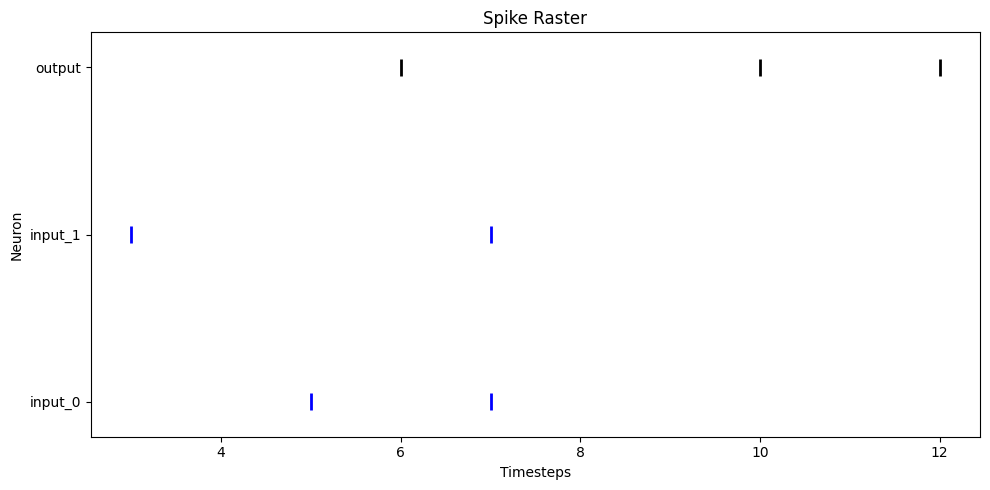

In [42]:
import matplotlib.pyplot as plt

network_spikes = []
for neuron_id in neurons.values():
    network_spikes.append(list(multibreed_model.get_spikes(neuron_id)))

colors1 = ['b', 'b', 'k']  #Input spikes in blue and network spikes in black
fig, axs = plt.subplots(1,1,figsize=(10,5))
axs.eventplot(network_spikes,colors=colors1,lineoffsets=1,linelengths=0.1,linewidths=2.0)
axs.set_yticks([0, 1, 2])
axs.set_yticklabels(['input_0', 'input_1', 'output'])
plt.title('Spike Raster')
plt.xlabel('Timesteps')
plt.ylabel('Neuron')
plt.tight_layout()

Writing your own step functions is out of scope for this tutorial. Examples of what these step functions should look like are provided here: https://github.com/ORNL/superneuroabm/blob/main/superneuroabm/neuron.py